This notebook is meant to be run on colab. If running locally, do setup locally and comment out the setup block below.

In [ ]:
# setup

!git clone https: // github.com/derpyplops/SAELens.git
%cd SAELens
!pip install -qe.
!pip freeze | grep -q "https://github.com/derpyplops/SAELens.git" & & echo "The package is installed." | | echo "The package is not installed."

In [1]:
import sys

from sae_lens.training.evals import run_evals
from sae_lens.training.activations_store import ActivationsStore
import transformer_lens
from tests.unit.helpers import build_sae_cfg
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import torch
import numpy as np
import datasets
from io import BytesIO

print(sys.version)
%load_ext autoreload
%autoreload 2

DEVICE = "cuda"  # or cuda or cpu or mps

3.11.8 (main, Feb 26 2024, 15:36:12) [Clang 14.0.6 ]


In [2]:
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

saes, sparsities = get_gpt2_res_jb_saes(device=DEVICE)

100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


In [3]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small", device=DEVICE)
cfg = build_sae_cfg(
    checkpoint_path="./checkpoints",
    train_batch_size=1000,  # TODO i dunno what this is
    total_training_tokens=300 * (10 ** 6),
    context_size=128,
    device=DEVICE,
    d_in=768,
)

dataset = datasets.load_dataset("NeelNanda/openwebtext-tokenized-9b", streaming=True)
activation_store = ActivationsStore.from_config(model, cfg, dataset=dataset['train'])
res = {}
ctx = {
    "suffix": "",
    "n_training_steps": 42,
}


def run_all_evals():
    for name, sae in tqdm(saes.items(), desc="Evaluating SAEs"):
        metrics = run_evals(sae, activation_store, model, ctx)
        res[name] = metrics.as_dict(suffix="")

    with open("gpt2_small_metrics.json", "w") as f:
        json.dump(res, f)


run_all_evals()

Loaded pretrained model gpt2-small into HookedTransformer
Run name: 128-L1-0.002-LR-0.0002-Tokens-1.000e+06
n_tokens_per_buffer (millions): 4.8e-05
Lower bound: n_contexts_per_buffer (millions): 8e-06
Total training steps: 250000
Total wandb updates: 25000
n_tokens_per_feature_sampling_window (millions): 0.0012
n_tokens_per_dead_feature_window (millions): 0.024
We will reset the sparsity calculation 5000 times.
Number tokens in sparsity calculation window: 2.00e+02


Resolving data files:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating SAEs: 100%|██████████| 13/13 [02:03<00:00,  9.51s/it]


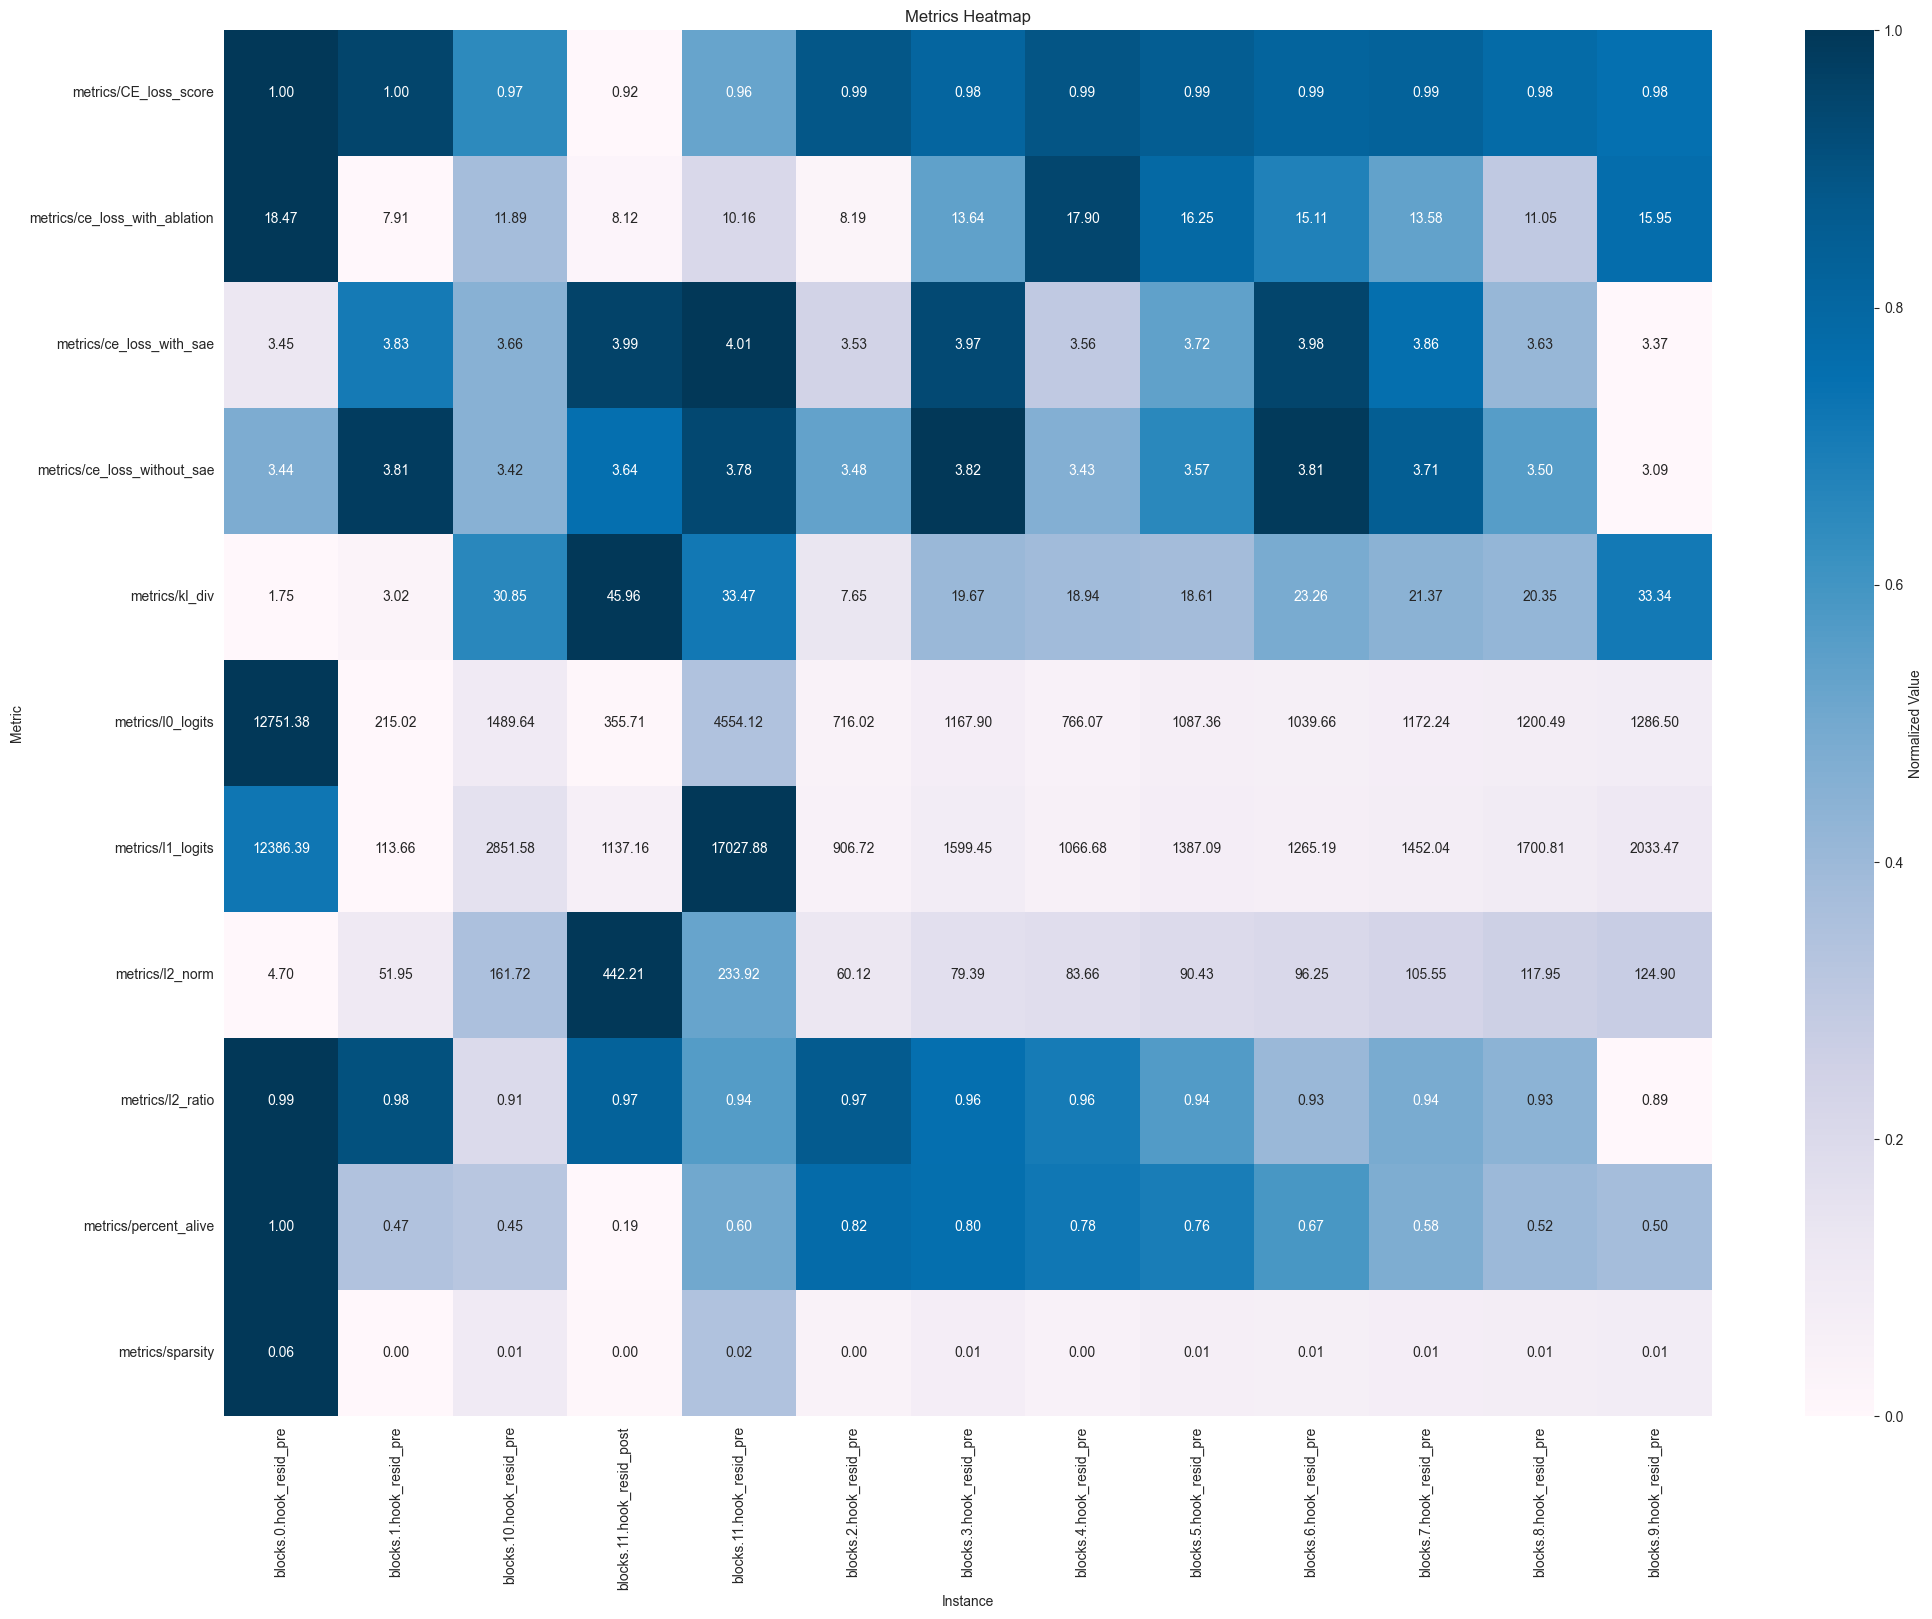

<Figure size 640x480 with 0 Axes>

In [4]:
def create_heatmap(metrics_dict):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_melted = pd.melt(df.reset_index(), id_vars='index', var_name='Metric', value_name='Value')
    df_pivot = df_melted.pivot(index='Metric', columns='index', values='Value')

    def normalize_row(row):
        if row.max() == row.min():
            return pd.Series(0.0, index=row.index)
        else:
            return (row - row.min()) / (row.max() - row.min())

    df_normalized = df_pivot.apply(normalize_row, axis=1)
    cmap = sns.color_palette("PuBu", as_cmap=True)
    plt.figure(figsize=(24, 18))
    sns.heatmap(df_normalized, cmap=cmap, annot=df_pivot, fmt='.2f', cbar_kws={'label': 'Normalized Value'},
                annot_kws={"size": 10})
    plt.title('Metrics Heatmap')
    plt.xlabel('Instance')
    plt.ylabel('Metric')

    plt.show()

    # plt.savefig("gpt2_small_metrics_heatmap.png")


# with open("gpt2_small_metrics.json", "r") as f:
#     metrics = json.load(f)

create_heatmap(res)


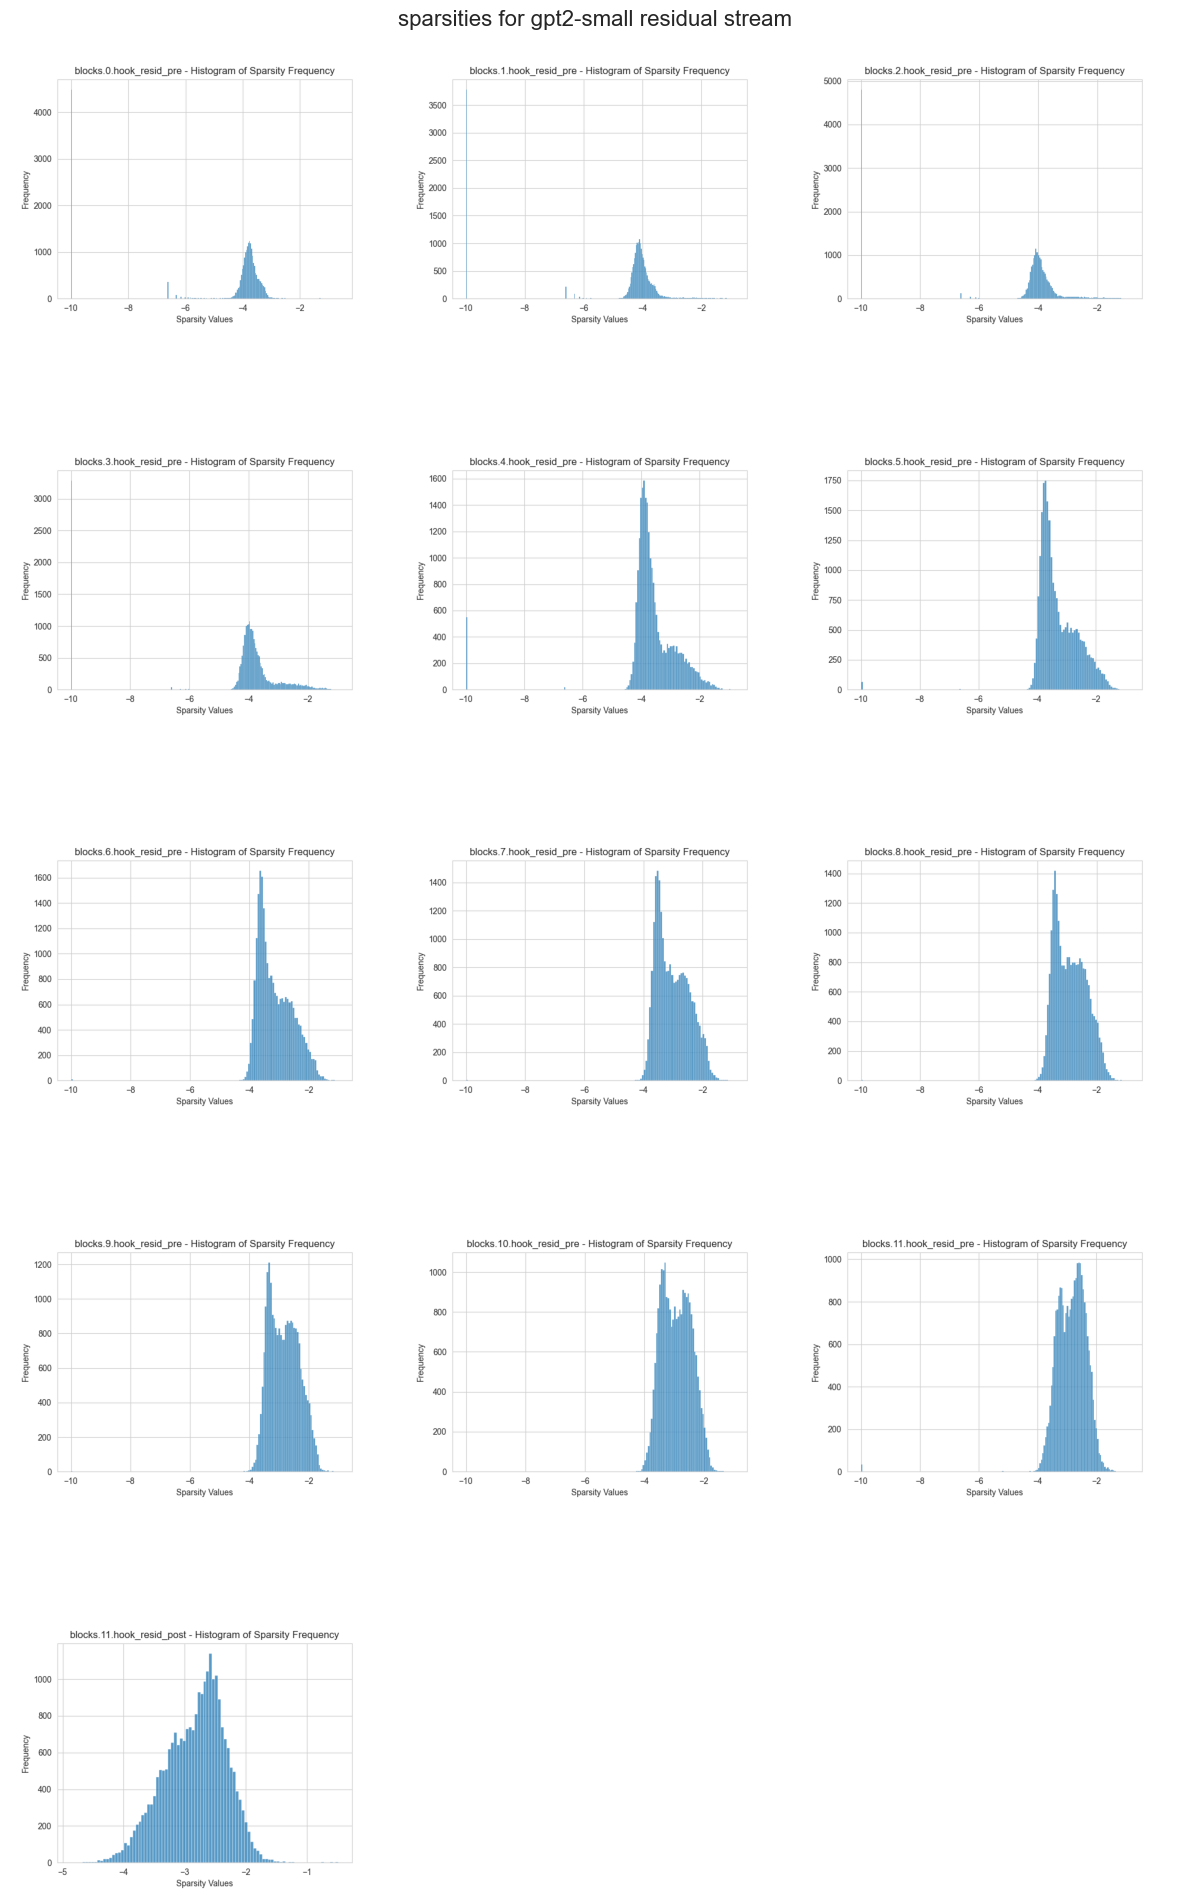

In [5]:
def make_histogram(sparsity, title):
    sparsity_np = sparsity.numpy()
    fig, ax = plt.subplots()
    sns.histplot(sparsity_np, kde=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Sparsity Values')
    ax.set_ylabel('Frequency')
    buffer = BytesIO()
    fig.savefig(buffer, format='png')
    buffer.seek(0)
    plt.close(fig)
    return buffer


def create_subplots(sparsities):
    sparsities = {k: v.cpu() for k, v in sparsities.items()}
    n_saes = len(sparsities)
    n_cols = 3
    n_rows = (n_saes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()
    for i, (name, sparsity) in enumerate(sparsities.items()):
        # Create histogram subplot
        buffer_hist = make_histogram(sparsity, f"{name} - Histogram of Sparsity Frequency")
        axes[i].imshow(plt.imread(buffer_hist))
        axes[i].axis('off')

    # Remove any excess subplots
    for i in range(n_saes, n_rows * n_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    fig.suptitle(f'sparsities for gpt2-small residual stream', fontsize=16)

    return fig


fig = create_subplots(sparsities)